# Modeling 3: Neural Network

- **Author**: Dan O'Connor
- **Notebook**: 6 of 9

In this notebook I run a baseline neural network (NN) and then try to optimize it. I recognize there are more steps to be taken in NN optimization than done here that involve more trial and error but this will be a good starting point. 

Import required libraries.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive #colab

In [2]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


Load in previous dataframes.

In [4]:
subset_model_df = pd.read_csv('Data/subset_model_df.csv')

In [30]:
accuracy_df = pd.read_csv('Data/accuracy_df2.csv', index_col='Model')

In [31]:
scores_df = pd.read_csv('Data/scores_df2.csv', index_col = 'Genres')

In [32]:
accuracy_df

,Baseline Accuracy,Optimized Accuracy
Model,,
Baseline,0.29,NaN
Logistic Regression,0.66,0.66
KNN,0.62,0.63
Random Forest,0.64,0.64
Decision Tree,0.47,0.52
Neural Net,NaN,NaN
SMOTE Neural Net,NaN,NaN


Label encode indep. variable then split the data and scale first on the train only before fitting to the test.

In [5]:
X = subset_model_df.drop(columns='genre_top')
y = subset_model_df['genre_top']

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encoder object
label_encoder = LabelEncoder()

# Fit the encoder on y
label_encoder.fit(y)

# Transform
y_encoded = label_encoder.transform(y)

Using the same processes as previous notebooks, including random states so the models can be compared fairly to each other.

In [48]:
from sklearn.model_selection import train_test_split
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.25, stratify=y_encoded,random_state=1) 

In [8]:
from my_functions import get_class_metrics # import function

In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler() #instaniate scaler
X_train_scaled = scaler.fit_transform(X_train) #fit and transform to x train
X_test_scaled = scaler.transform(X_test) #transform x test

## Neural Network

### Baseline

For my baseline NN, I included only one hidden layer before the output layer. I intended for a simple model trained only on 50 epochs. I used softmax as the activation layer on the final layer because it converts the output of the model into probabilities for each class (note how the number of neurons on my final layer is the number of different classes). I used the 'adam' optimizer with the loss function being sparse categorical crossentropy, which commonly used in multi-class classification. The metric I am measuring is accuracy.

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report

tf.random.set_seed(42) #random seed 
 
# Define the model
model = keras.Sequential() #sequential model
model.add(layers.Dense(64, activation='relu', input_dim=X_train.shape[1])) #input dim same size as num of cols
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax')) #softmax for proba/classs

# Compile 
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=3) #fit to trained and scaled data

# Evaluate
loss, baseline_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", baseline_nn_accuracy)
#predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
baseline_nn_class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
372/372 [==============================] - 1s 2ms/step - loss: 1.3883 - accuracy: 0.6484
Accuracy: 0.6483849287033081
372/372 [==============================] - 1s 1ms/step


Add the results to their respective dataframes.

In [33]:
accuracy_df.loc['Neural Net', 'Baseline Accuracy'] = round(baseline_nn_accuracy,2)
print('Baseline Accuracy: ', baseline_nn_accuracy)

Baseline Accuracy:  0.6451884508132935


In [34]:
get_class_metrics(baseline_nn_class_report, 'baseline_nn',scores_df)

### Optimized

Using a grid search to optimize a NN is not straight forward, so my approach was to tune hyperparameters using a validation set. To double check and ensure no data leakage happened, I redefined my variables below and went through the process of splitting to train, test, and validation sets. Then I fit the standard scaler to my training set, then transformed the validation and test sets.

In [11]:
X = subset_model_df.drop(columns='genre_top')
y = subset_model_df['genre_top']

In [12]:
X.shape, y_encoded.shape #confirming

((47549, 350), (47549,))

In [40]:
from sklearn.model_selection import train_test_split
#split data with same random spliit
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.25, stratify=y_encoded,random_state=1)


In [41]:
X_train.shape, y_train.shape #confirming

((35661, 350), (35661,))

In [42]:
#split once again to attain val sets
X_train_subset, X_val, y_train_subset, y_val = train_test_split(X_train,y_train, test_size=0.25, stratify=y_train,random_state=1)

In [43]:

scaler = StandardScaler() #instantiate scaler

scaler.fit(X_train_subset) #fit to x train

# transform the X_train_subset, X_val, and X_test data using the fitted scaler
X_train_subset_scaled = scaler.transform(X_train_subset)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

The two metrics I am going to keep track of during this optimization is model accuracy and model loss. The goal is to maximize accuracy and mimimize loss, which is a measure of how well the model is able to minimize the difference between the predicted output and the actual output. After each iteration, graphs of both will be shown. My overall approach to this optimization was to start with a complex model that likely overfits with lots of layers and prune back based on how the model is performing. 

In [44]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(42)

# Define the model

# Define the model with many layers
model = keras.Sequential() #sequential model
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1])) #128 neurons
model.add(layers.Dense(64, activation='relu')) #64 neurons
model.add(layers.Dense(32, activation='relu')) #32 neurons
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax')) #9 neurons

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train_subset_scaled, y_train_subset,  #fit on scaled train subsets
                    epochs=25, #start small epoochs
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val))#usinig val 

# Evaluate the model on the test set
loss, overfitted_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", overfitted_nn_accuracy)

# Generate predictions on the test set
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# Print the classification report
optimized_nn_class_report = classification_report(y_test, y_pred, output_dict=True)

Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
372/372 [==============================] - 1s 2ms/step - loss: 2.2855 - accuracy: 0.6263
Accuracy: 0.6263458728790283
372/372 [==============================] - 1s 2ms/step


Almost immediately, it can be seen that this model is overfitting. This is because the validation sets accuracy decreases and loss increases while the training sets accuracy increases and loss decreases.

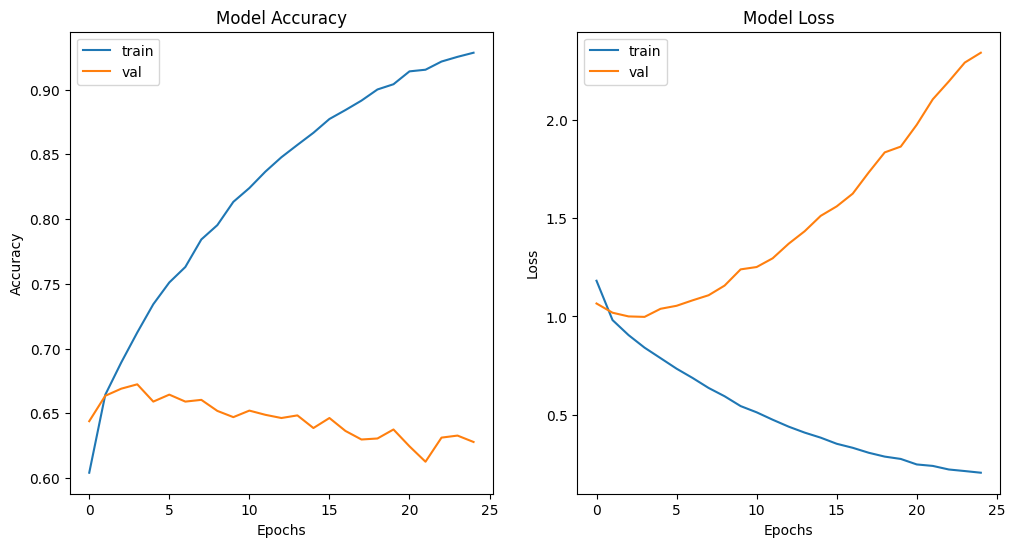

In [45]:
#plot model acc and model loss with two subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy']) #pull from history
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

The next step I took was to add some method to better generalize. I chose to add dropout layers inbetween the dense layers. Somewhat arbitrarily, I chose the dropout to be 0.5. (another parameter I could have further tuned.)

In [46]:
tf.random.set_seed(42)

# Define the model 
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5)) #added 0.5 dropout layer
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax')) 

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with validation data
history = model.fit(X_train_subset_scaled, y_train_subset, 
                    epochs=25, 
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val)) 

#evaluate
loss, overfitted_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", overfitted_nn_accuracy)

# Generate predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
optimized_nn_class_report = classification_report(y_test, y_pred, output_dict=True)



Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25
Epoch 25/25
372/372 [==============================] - 1s 2ms/step - loss: 1.0394 - accuracy: 0.6659
Accuracy: 0.6658815741539001
372/372 [==============================] - 1s 1ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Now it can be seen that the validation accuracy is increasing while its loss is decreasing. This is a good sign and suggests that I should train the model for more epochs to see where the divergence occurs.

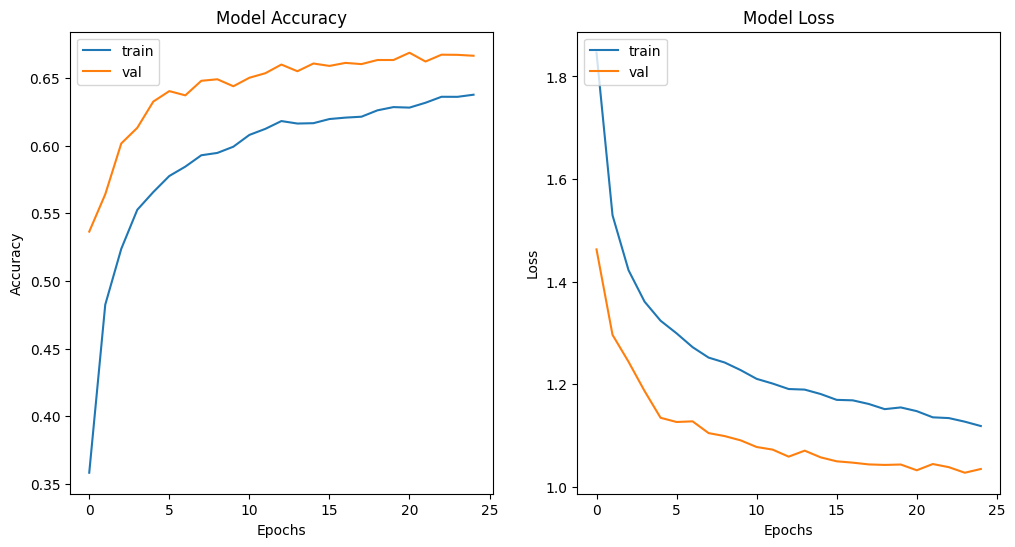

In [47]:
#plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

Below, I set the epochs to 100. Note: The graphs are at the bottom of the output, after the 100th epoch. After 100 epochs, it appears that the validation accuracy is still increasing. 

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


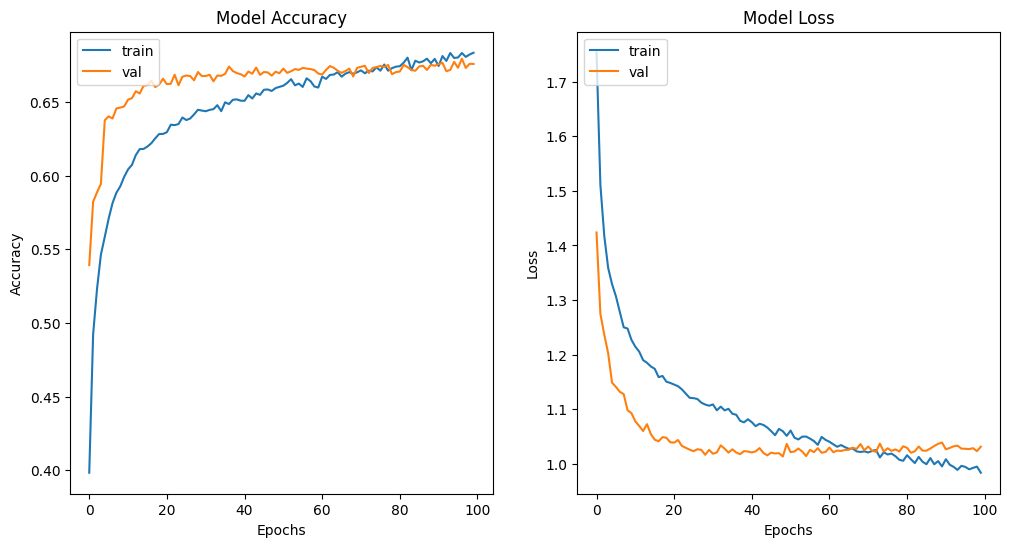

In [22]:
tf.random.set_seed(42)

# Using the same setup as previously.
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Increasing thhe epochs here to 100
history = model.fit(X_train_subset_scaled, y_train_subset, 
                    epochs=100, 
                    batch_size=32, 
                    verbose=3,
                    validation_data=(X_val_scaled, y_val))

# Evaluate the model
loss, overfitted_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", overfitted_nn_accuracy)

#predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

#classification report
optimized_nn_class_report = classification_report(y_test, y_pred, output_dict=True)

#plotting val and train
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

Finally, I train the model for 200 epochs to see where the divergence between train and validation occurs.

In [23]:
tf.random.set_seed(42)

# Same setup as before
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Same as before except with 200 epochs
history = model.fit(X_train_subset_scaled, y_train_subset, 
                    epochs=200, 
                    batch_size=32, 
                    # verbose=3,
                    validation_data=(X_val_scaled, y_val))

# Evaluate the model 
loss,optimized_nn_accuracy = model.evaluate(X_test_scaled, y_test) 
print("Accuracy:", optimized_nn_accuracy)

# Generate predictions
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

# class report
optimized_nn_class_report = classification_report(y_test, y_pred, output_dict=True)



Epoch 1/200
836/836 [==============================] - 6s 5ms/step - loss: 1.8006 - accuracy: 0.3637 - val_loss: 1.4369 - val_accuracy: 0.5233
Epoch 2/200
836/836 [==============================] - 4s 5ms/step - loss: 1.5153 - accuracy: 0.4861 - val_loss: 1.3037 - val_accuracy: 0.5574
Epoch 3/200
836/836 [==============================] - 3s 4ms/step - loss: 1.4199 - accuracy: 0.5280 - val_loss: 1.2272 - val_accuracy: 0.6123
Epoch 4/200
836/836 [==============================] - 3s 4ms/step - loss: 1.3601 - accuracy: 0.5546 - val_loss: 1.1906 - val_accuracy: 0.6264
Epoch 5/200
836/836 [==============================] - 5s 5ms/step - loss: 1.3153 - accuracy: 0.5685 - val_loss: 1.1387 - val_accuracy: 0.6373
Epoch 6/200
836/836 [==============================] - 4s 5ms/step - loss: 1.2936 - accuracy: 0.5783 - val_loss: 1.1263 - val_accuracy: 0.6430
Epoch 7/200
836/836 [==============================] - 3s 4ms/step - loss: 1.2699 - accuracy: 0.5878 - val_loss: 1.1092 - val_accuracy: 0.6503

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Visually, it looks like right around 100 epochs is the where the divergence occured. It was worth double checking. I will use this information to train my final optimized model. There are many other hyperparameters I could have tuned such as: learning rate, activation functions, number of layers/neurons, and batch size. I plan to implement these at a later date.

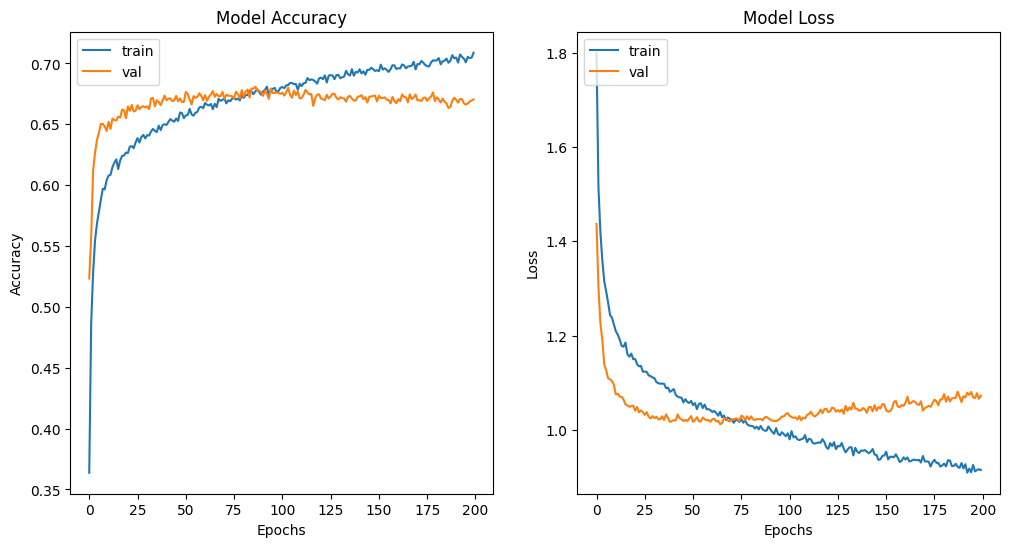

In [24]:

#ploot accuracy and model loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['train', 'val'], loc='upper left')

plt.show()

Taking the epoch information from above, I train and save my final model then add its testing success metrics to their dataframes.

In [27]:


# Final model (same architecture as before)
model = keras.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=X_train_subset.shape[1]))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train using 100 epochs
history = model.fit(X_train_subset_scaled, y_train_subset, 
                    epochs=100, 
                    batch_size=32, 
                    )

# Evaluate the model on the test set
loss, final_nn_accuracy = model.evaluate(X_test_scaled, y_test)
print("Accuracy:", final_nn_accuracy)

# Generate predictions 
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)


final_nn_class_report = classification_report(y_test, y_pred, output_dict=True)

model.save('final_nn_model.h5') #save the model to access later

Epoch 1/100
836/836 [==============================] - 4s 3ms/step - loss: 1.7588 - accuracy: 0.3989
Epoch 2/100
836/836 [==============================] - 3s 4ms/step - loss: 1.4964 - accuracy: 0.4950
Epoch 3/100
836/836 [==============================] - 4s 5ms/step - loss: 1.4067 - accuracy: 0.5328
Epoch 4/100
836/836 [==============================] - 3s 3ms/step - loss: 1.3484 - accuracy: 0.5563
Epoch 5/100
836/836 [==============================] - 3s 4ms/step - loss: 1.3020 - accuracy: 0.5708
Epoch 6/100
836/836 [==============================] - 3s 3ms/step - loss: 1.2856 - accuracy: 0.5859
Epoch 7/100
836/836 [==============================] - 4s 4ms/step - loss: 1.2602 - accuracy: 0.5894
Epoch 8/100
836/836 [==============================] - 3s 4ms/step - loss: 1.2492 - accuracy: 0.5912
Epoch 9/100
836/836 [==============================] - 3s 3ms/step - loss: 1.2301 - accuracy: 0.5985
Epoch 10/100
836/836 [==============================] - 3s 3ms/step - loss: 1.2193 - accura

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model summary shown below shows the total number of trainable parameters, over 55,000. 

In [28]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               44928     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 9)                

In [36]:
accuracy_df.loc['Neural Net', 'Optimized Accuracy'] = round(optimized_nn_accuracy,2)
print('Optimized Accuracy: ', optimized_nn_accuracy)


Optimized Accuracy:  0.6655451059341431


In [37]:
get_class_metrics(optimized_nn_class_report, 'optimized_nn',scores_df)

Save the dataframes for next notebook.

In [38]:
scores_df.to_csv('Data/scores_df3.csv')

In [39]:
accuracy_df.to_csv('Data/accuracy_df3.csv')